# Viral tissue concentrations
This notebook uses the data extracted from studies in rhesus macaques to estimate the viral concentration within different  tissues

Importing libraries for dealing with the data and plotting

In [20]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

mpl.style.use('seaborn')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [10, 7],'figure.dpi': 300,
                     'axes.labelsize': 20, 'xtick.labelsize': 18,
                     'ytick.labelsize': 18, 'axes.titlesize': 20,
                     'legend.title_fontsize':15, 'legend.fontsize': 15,
                      'legend.facecolor': 'white', 'legend.framealpha': 0.8,
                     'legend.edgecolor':'black', 'legend.frameon': True,
                     'legend.fancybox': True, 'legend.shadow': True})


## Data preprocess
Loading the data and filtering it.
We want to focus on samples taken not more than 4 days from infection, to ensure they are close to the peak 

In [42]:
merg_data = pd.read_excel('merged_RM_data.xlsx')


## RNA copies/g data
Most of the studies measured the viral genomic concentrations

In [43]:
merg_data.loc[merg_data['log10 RNA Copies/g'] =='<L.O.D.', 'log10 RNA Copies/g'] = np.nan
# merg_data['log10 RNA Copies/g']
merg_data['log10 RNA Copies/g'] = pd.to_numeric(merg_data['log10 RNA Copies/g'])

filt_data = merg_data.copy()
filt_data = filt_data.loc[filt_data.Reference != 'Rockx et al.'] # This source contain only TCID50 measurements
filt_data = filt_data.loc[filt_data.Reference != 'Singh et al.']  # This source contain only very late measurements (12-14 days post inoculation)
filt_data = filt_data.loc[filt_data.Reference != 'Zheng et al.']  # this source is aggregated differently and its results are strange compare to 
# filt_data = filt_data.loc[filt_data.Location != 'Nares / Pharynx']
filt_data.rename(columns={'Day (post incoulation)': 'dpi_'}, inplace=True)
filt_data.dpi_ = pd.to_numeric(filt_data.dpi_)

# defining a threshold at 4 days to ensure the data is from samples that are close to the peak
thresh = 4
filt_data['measurement'] = 'late'
filt_data.loc[filt_data.dpi_ <= thresh, 'measurement'] = 'early'

### Aggregation by animals
We want to characterize the possible variation between animals, and to esimate the uncertainty of the mean.
We don't consider measurements that hadn't reach the limit of detection, to avoid biasing the results down, due to local differences within the tissue.
(even if a certian small portion of the tissue has little amount of virions, it overall effect on the concentration is little as they distribute log-normal)

In [23]:
# defining a function to calculate the standard error of the mean without considering nans
def nansem(v):
    return np.nanstd(v)/np.sqrt(sum(~np.isnan(v)))
agg_by_animal = filt_data.pivot_table(index=['Location','Reference','animal ID','dpi_','number of animals'], values='log10 RNA Copies/g', aggfunc=[np.nanmean, np.nanstd, nansem])

agg_by_animal['dpi'] = agg_by_animal.index.get_level_values(3)  
agg_by_animal = agg_by_animal.sort_values(['Location','dpi', 'Reference'])
agg_by_animal['num_animals'] =  agg_by_animal.index.get_level_values(4) 
# There is no differentiation according to the animals in Williamson et al.so they are all aggregated and hence should get more weight in calculations
agg_by_animal.loc[('Lungs','Williamson et al.','1-6'), 'num_animals'] = 6
agg_by_animal.loc[('Trachea and Bronchus','Williamson et al.','1-6'), 'num_animals'] = 6
agg_by_animal.index = agg_by_animal.index.droplevel([3,4])
agg_by_animal

C:\Users\ronse\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ronse\Anaconda3\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


nanmean  \
                                                   log10 RNA Copies/g   
Location             Reference           animal ID                      
GI                   Chandrasheka et al. 2a                       3.5   
                                         2b                       3.8   
                     Munster et al.      RM1                      4.2   
                                         RM2                      3.2   
                                         RM3                      4.2   
...                                                               ...   
Trachea and Bronchus Deng et al. (2)     IT-1                     6.6   
                     Williamson et al.   1-6                      4.5   
                     Yadav et al.        B                        3.7   
                                         C                        2.7   
                                         D                        2.9   

                                                               nanstd  \
                                                   log10 RNA Copies/g   
Location             Reference           animal ID                      
GI                   Chandrasheka et al. 2a                       NaN   
                                         2b                       NaN   
                     Munster et al.      RM1                      NaN   
                                         RM2                      NaN   
                                         RM3                 0.282843   
...                                                               ...   
Trachea and Bronchus Deng et al. (2)     IT-1                     NaN   
                     Williamson et al.   1-6                      NaN   
                     Yadav et al.        B                        NaN   
                                         C                        NaN   
                                         D                        NaN   

                                                               nansem dpi  \
                                                   log10 RNA Copies/g       
Location             Reference           animal ID                          
GI                   Chandrasheka et al. 2a                  0.000000   2   
                                         2b                  0.000000   2   
                     Munster et al.      RM1                 0.000000   3   
                                         RM2                 0.000000   3   
                                         RM3                 0.141421   3   
...                                                               ...  ..   
Trachea and Bronchus Deng et al. (2)     IT-1                0.000000   7   
                     Williamson et al.   1-6                 0.000000   7   
                     Yadav et al.        B                   0.000000   7   
                                         C                   0.000000   7   
                                         D                   0.000000   7   

                                                   num_animals  
                                                                
Location             Reference           animal ID              
GI                   Chandrasheka et al. 2a                  1  
                                         2b                  1  
                     Munster et al.      RM1                 1  
                                         RM2                 1  
                                         RM3                 1  
...                                                        ...  
Trachea and Bronchus Deng et al. (2)     IT-1                1  
                     Williamson et al.   1-6                 6  
                     Yadav et al.        B                   1  
                                         C                   1  
                                         D                   1  

[94 rows x 5 columns]

### Concentrations in the lungs - RNA copies
As the lungs are the dominant contributors we first focus on the concentration measured in them

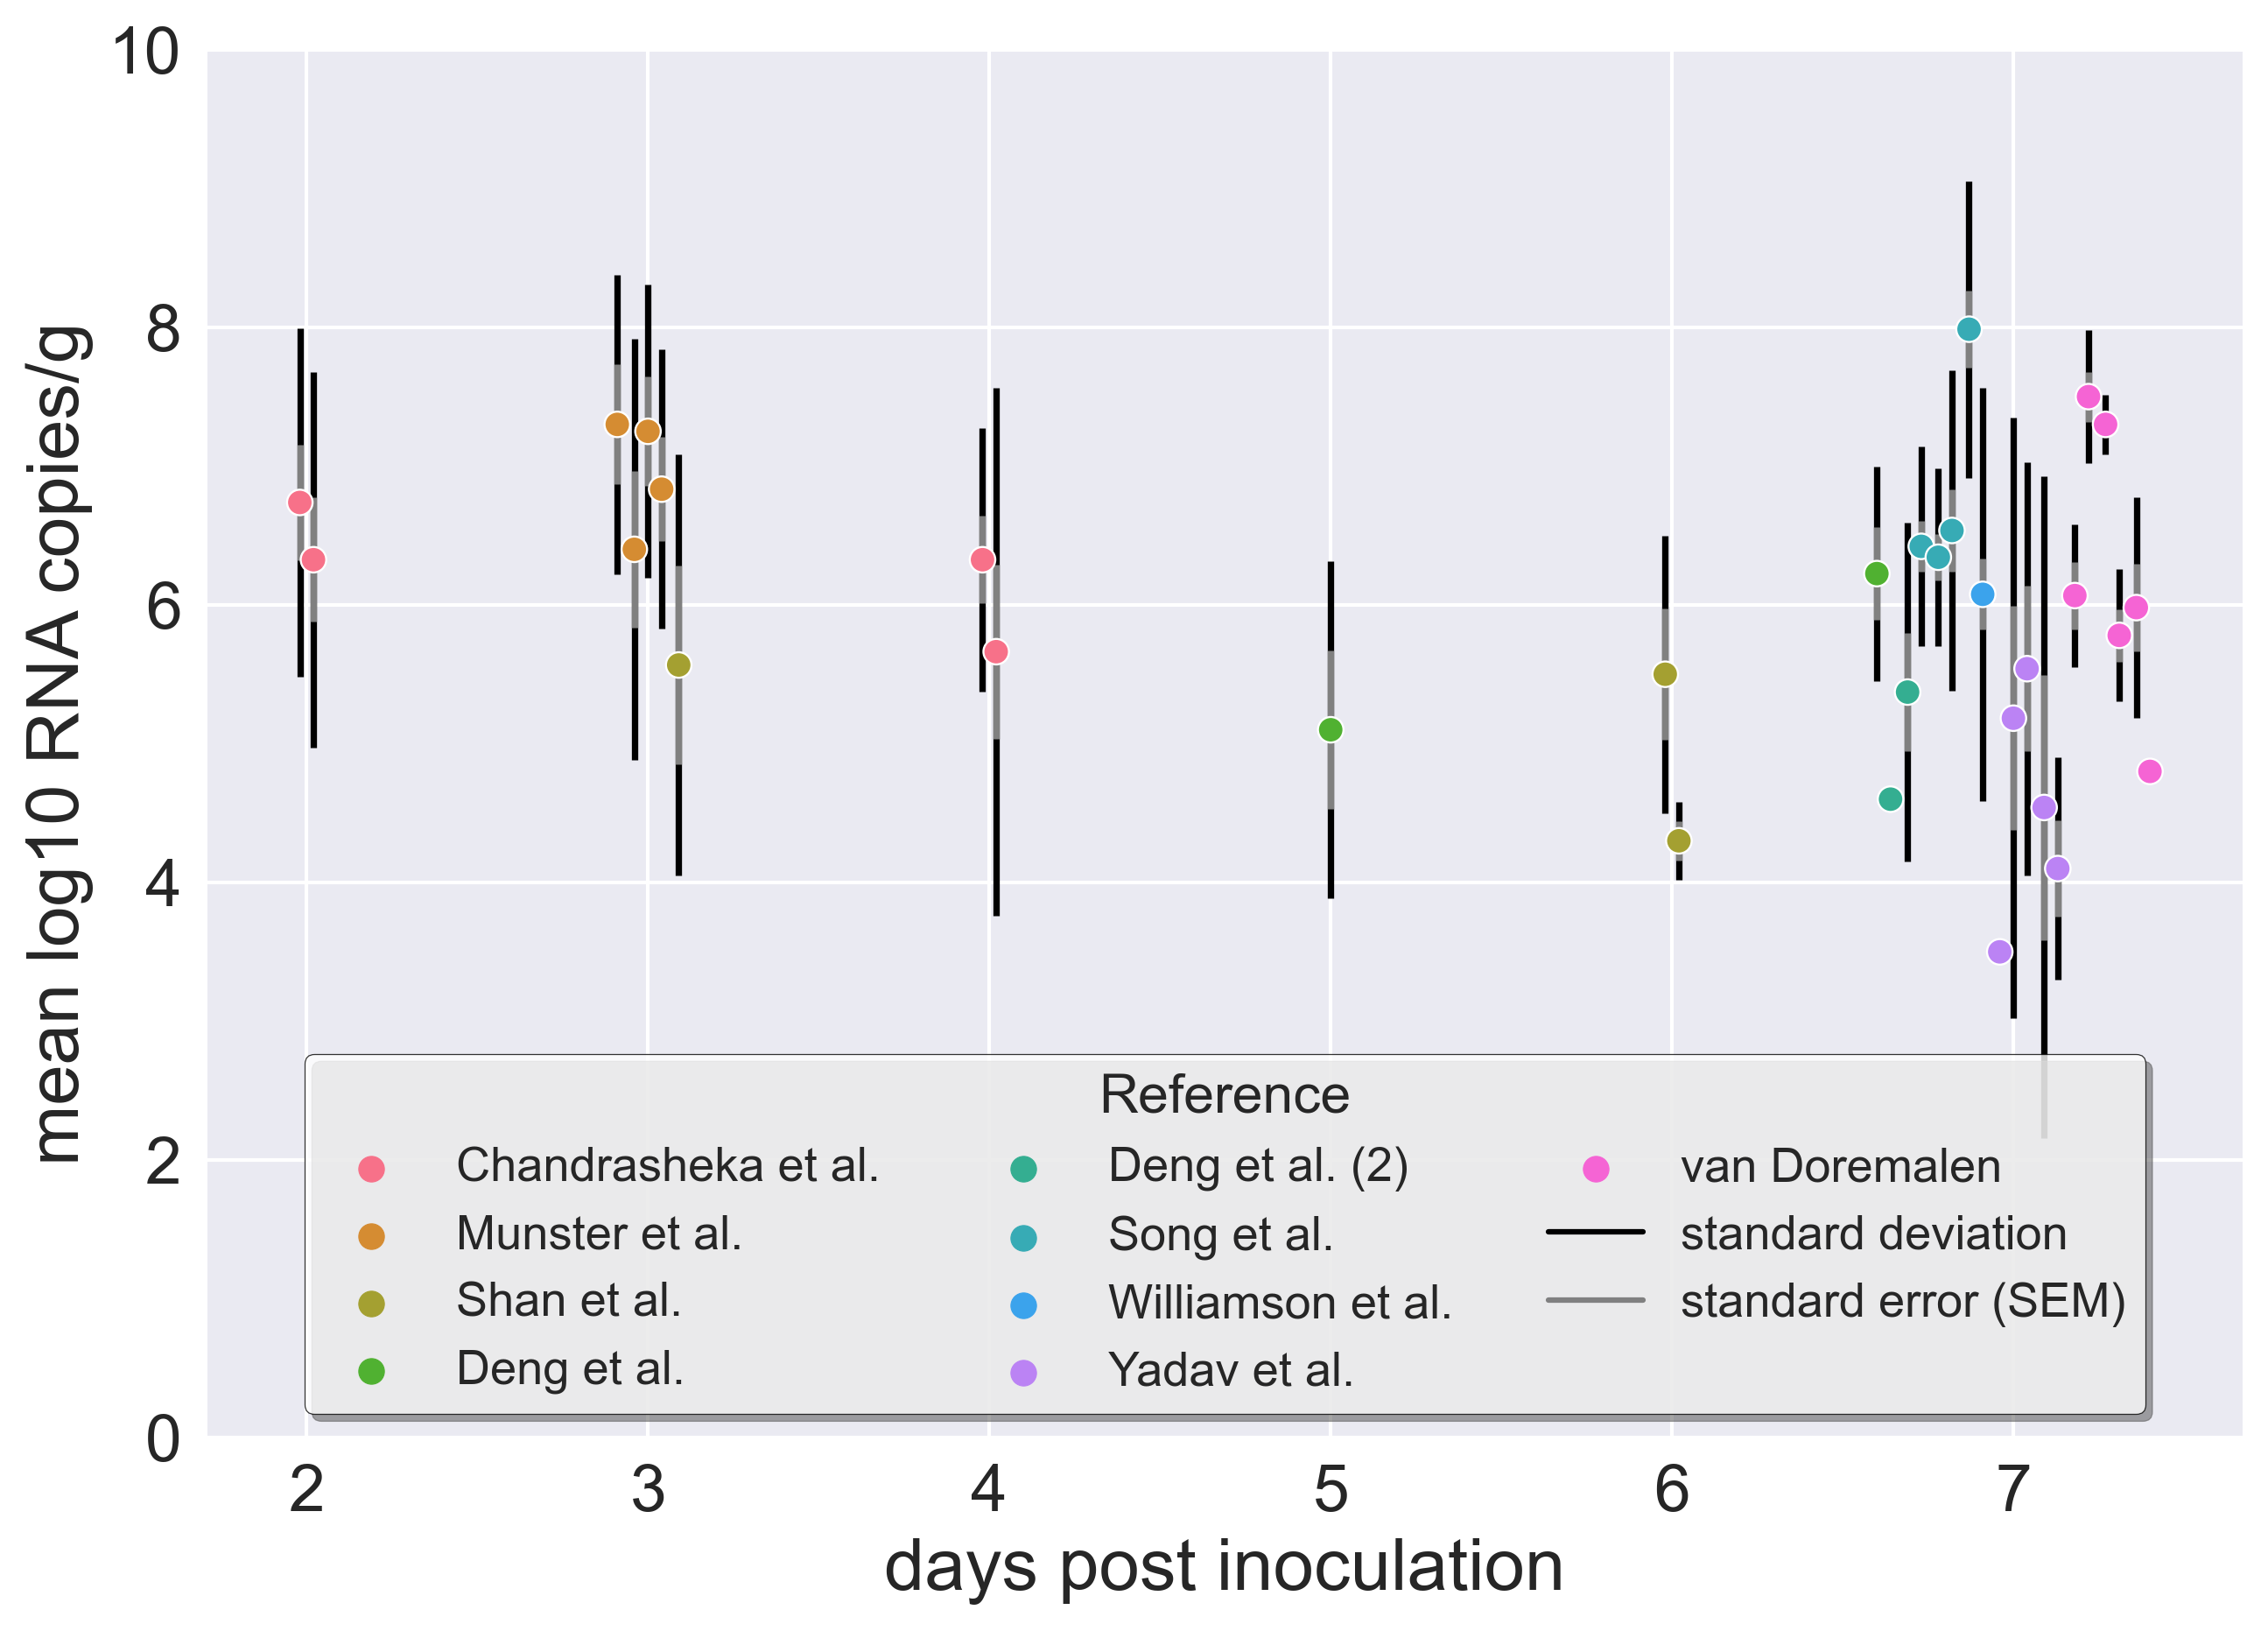

In [24]:
lungs_by_animals = agg_by_animal.loc['Lungs'].copy() 

### creating jitter array so the points wouldn't overlap
dpi_count = lungs_by_animals[['dpi']].groupby('dpi').size()
ww = 0.4
w = 2*ww/(dpi_count.max()-1)
jit = []
for d in dpi_count.index:
    nd = (dpi_count[d]-1)/2
    jit = jit + list(np.arange(-nd*w,(nd+0.99)*w,w).round(2))


plt.errorbar(lungs_by_animals.dpi + jit, lungs_by_animals['nanmean'].values.squeeze(), yerr=lungs_by_animals['nanstd'].values.squeeze(),
 ls='None', c='k', zorder=0.6)
plt.errorbar(lungs_by_animals.dpi + jit, lungs_by_animals['nanmean'].values.squeeze(), yerr=lungs_by_animals['nansem'].values.squeeze(),
 ls='None', c='grey', zorder=1)

sns.scatterplot(data=lungs_by_animals, x=lungs_by_animals.dpi + jit, y=('nanmean','log10 RNA Copies/g'), hue=lungs_by_animals.index.get_level_values(0))

#adding the lines for sem and std to the legend
handles, labels = plt.gca().get_legend_handles_labels() 
handles.append(Line2D([0],[0], lw=1.5, color='k',label='standard deviation'))
labels.append('standard deviation')
handles.append(Line2D([0],[0], lw=1.5, color='grey',label='standard error (SEM)'))
labels.append('standard error (SEM)')
plt.legend(handles=handles, labels=labels, title='Reference', fontsize=13, ncol=3, loc='lower center')



plt.ylabel('mean log10 RNA copies/g')
plt.ylim([0,10])
plt.xlabel('days post inoculation')
plt.savefig('mean copies per animals vs dpi.png')

### Summary by animal
We now want to summarize all the relevant statistics

In [25]:
# defining univariant function in order to calculate the interquantile range and the average weighted by the number of animals in aggregation
def perc_25(v):
    return np.percentile(v, q=25)

def perc_75(v):
    return np.percentile(v, q=75)

def mean_weighted_by_animals(v):
    return np.average(v, axis=0, weights=agg_by_animal.loc[v.index,'num_animals'].values.squeeze())

In [26]:
thresh = 4 #dpi
agg_by_animal['measurement'] = 'late'
agg_by_animal.loc[agg_by_animal.dpi <= thresh, 'measurement'] = 'early'
# using groupby together with agg function, we need to define dictionary - which function to use for which variable
agg_dict = {('nanmean','log10 RNA Copies/g'): [mean_weighted_by_animals, perc_25, perc_75, 'std'],
            ('nanstd','log10 RNA Copies/g'): 'mean',
            ('nansem','log10 RNA Copies/g'): 'mean',
            ('num_animals',''):'sum'}
summ_by_animal = agg_by_animal.groupby(['Location','measurement']).agg(agg_dict)
summ_by_animal.columns = ['mean_means', 'perc_25_means', 'perc_75_means', 'std_means', 'mean_stds', 'mean_sems', 'num_animals']

#calculating the total variation as the combination of the inter-animal and intra-animal varations
summ_by_animal['tot_var'] = summ_by_animal.mean_stds**2 + summ_by_animal.std_means**2
summ_by_animal['tot_std'] = summ_by_animal.tot_var**0.5
# calculating the total uncertainty in the estimate of the mean
summ_by_animal['tot_sem'] = (summ_by_animal.mean_sems**2 + summ_by_animal.std_means**2/summ_by_animal.num_animals)**0.5
summ_by_animal.round(1)

mean_means  perc_25_means  perc_75_means  \
Location             measurement                                             
GI                   early               3.8            3.4            4.2   
                     late                2.9            2.9            3.0   
Lungs                early               6.5            6.3            6.8   
                     late                5.7            4.9            6.3   
Nasal and Oropharynx early               5.5            5.0            5.9   
                     late                4.8            3.9            4.7   
Tonsil and LN        early               6.4            5.9            6.9   
                     late                4.6            3.6            5.6   
Trachea and Bronchus early               6.1            5.0            7.1   
                     late                4.5            3.7            5.2   

                                  std_means  mean_stds  mean_sems  \
Location             measurement                                    
GI                   early              0.7        0.3        0.0   
                     late               0.1        1.9        0.5   
Lungs                early              0.6        1.3        0.5   
                     late               1.1        1.0        0.3   
Nasal and Oropharynx early              0.8        0.7        0.3   
                     late               1.4        1.0        0.3   
Tonsil and LN        early              0.9        1.0        0.4   
                     late               1.3        0.8        0.1   
Trachea and Bronchus early              1.3        0.5        0.1   
                     late               1.3        0.8        0.1   

                                  num_animals  tot_var  tot_std  tot_sem  
Location             measurement                                          
GI                   early                  8      0.5      0.7      0.2  
                     late                   3      3.4      1.9      0.5  
Lungs                early                  9      2.0      1.4      0.5  
                     late                  27      2.3      1.5      0.4  
Nasal and Oropharynx early                  8      1.1      1.0      0.4  
                     late                  10      2.8      1.7      0.5  
Tonsil and LN        early                  8      1.8      1.3      0.5  
                     late                   8      2.2      1.5      0.5  
Trachea and Bronchus early                  9      2.0      1.4      0.5  
                     late                  14      2.3      1.5      0.4

### Summary on all samples
We also want to summarize the data when aggregating all the measurement, so to compensate for the low number of animals in the data.

Again we first take a look at the distribution of the concentration measured in the lung 

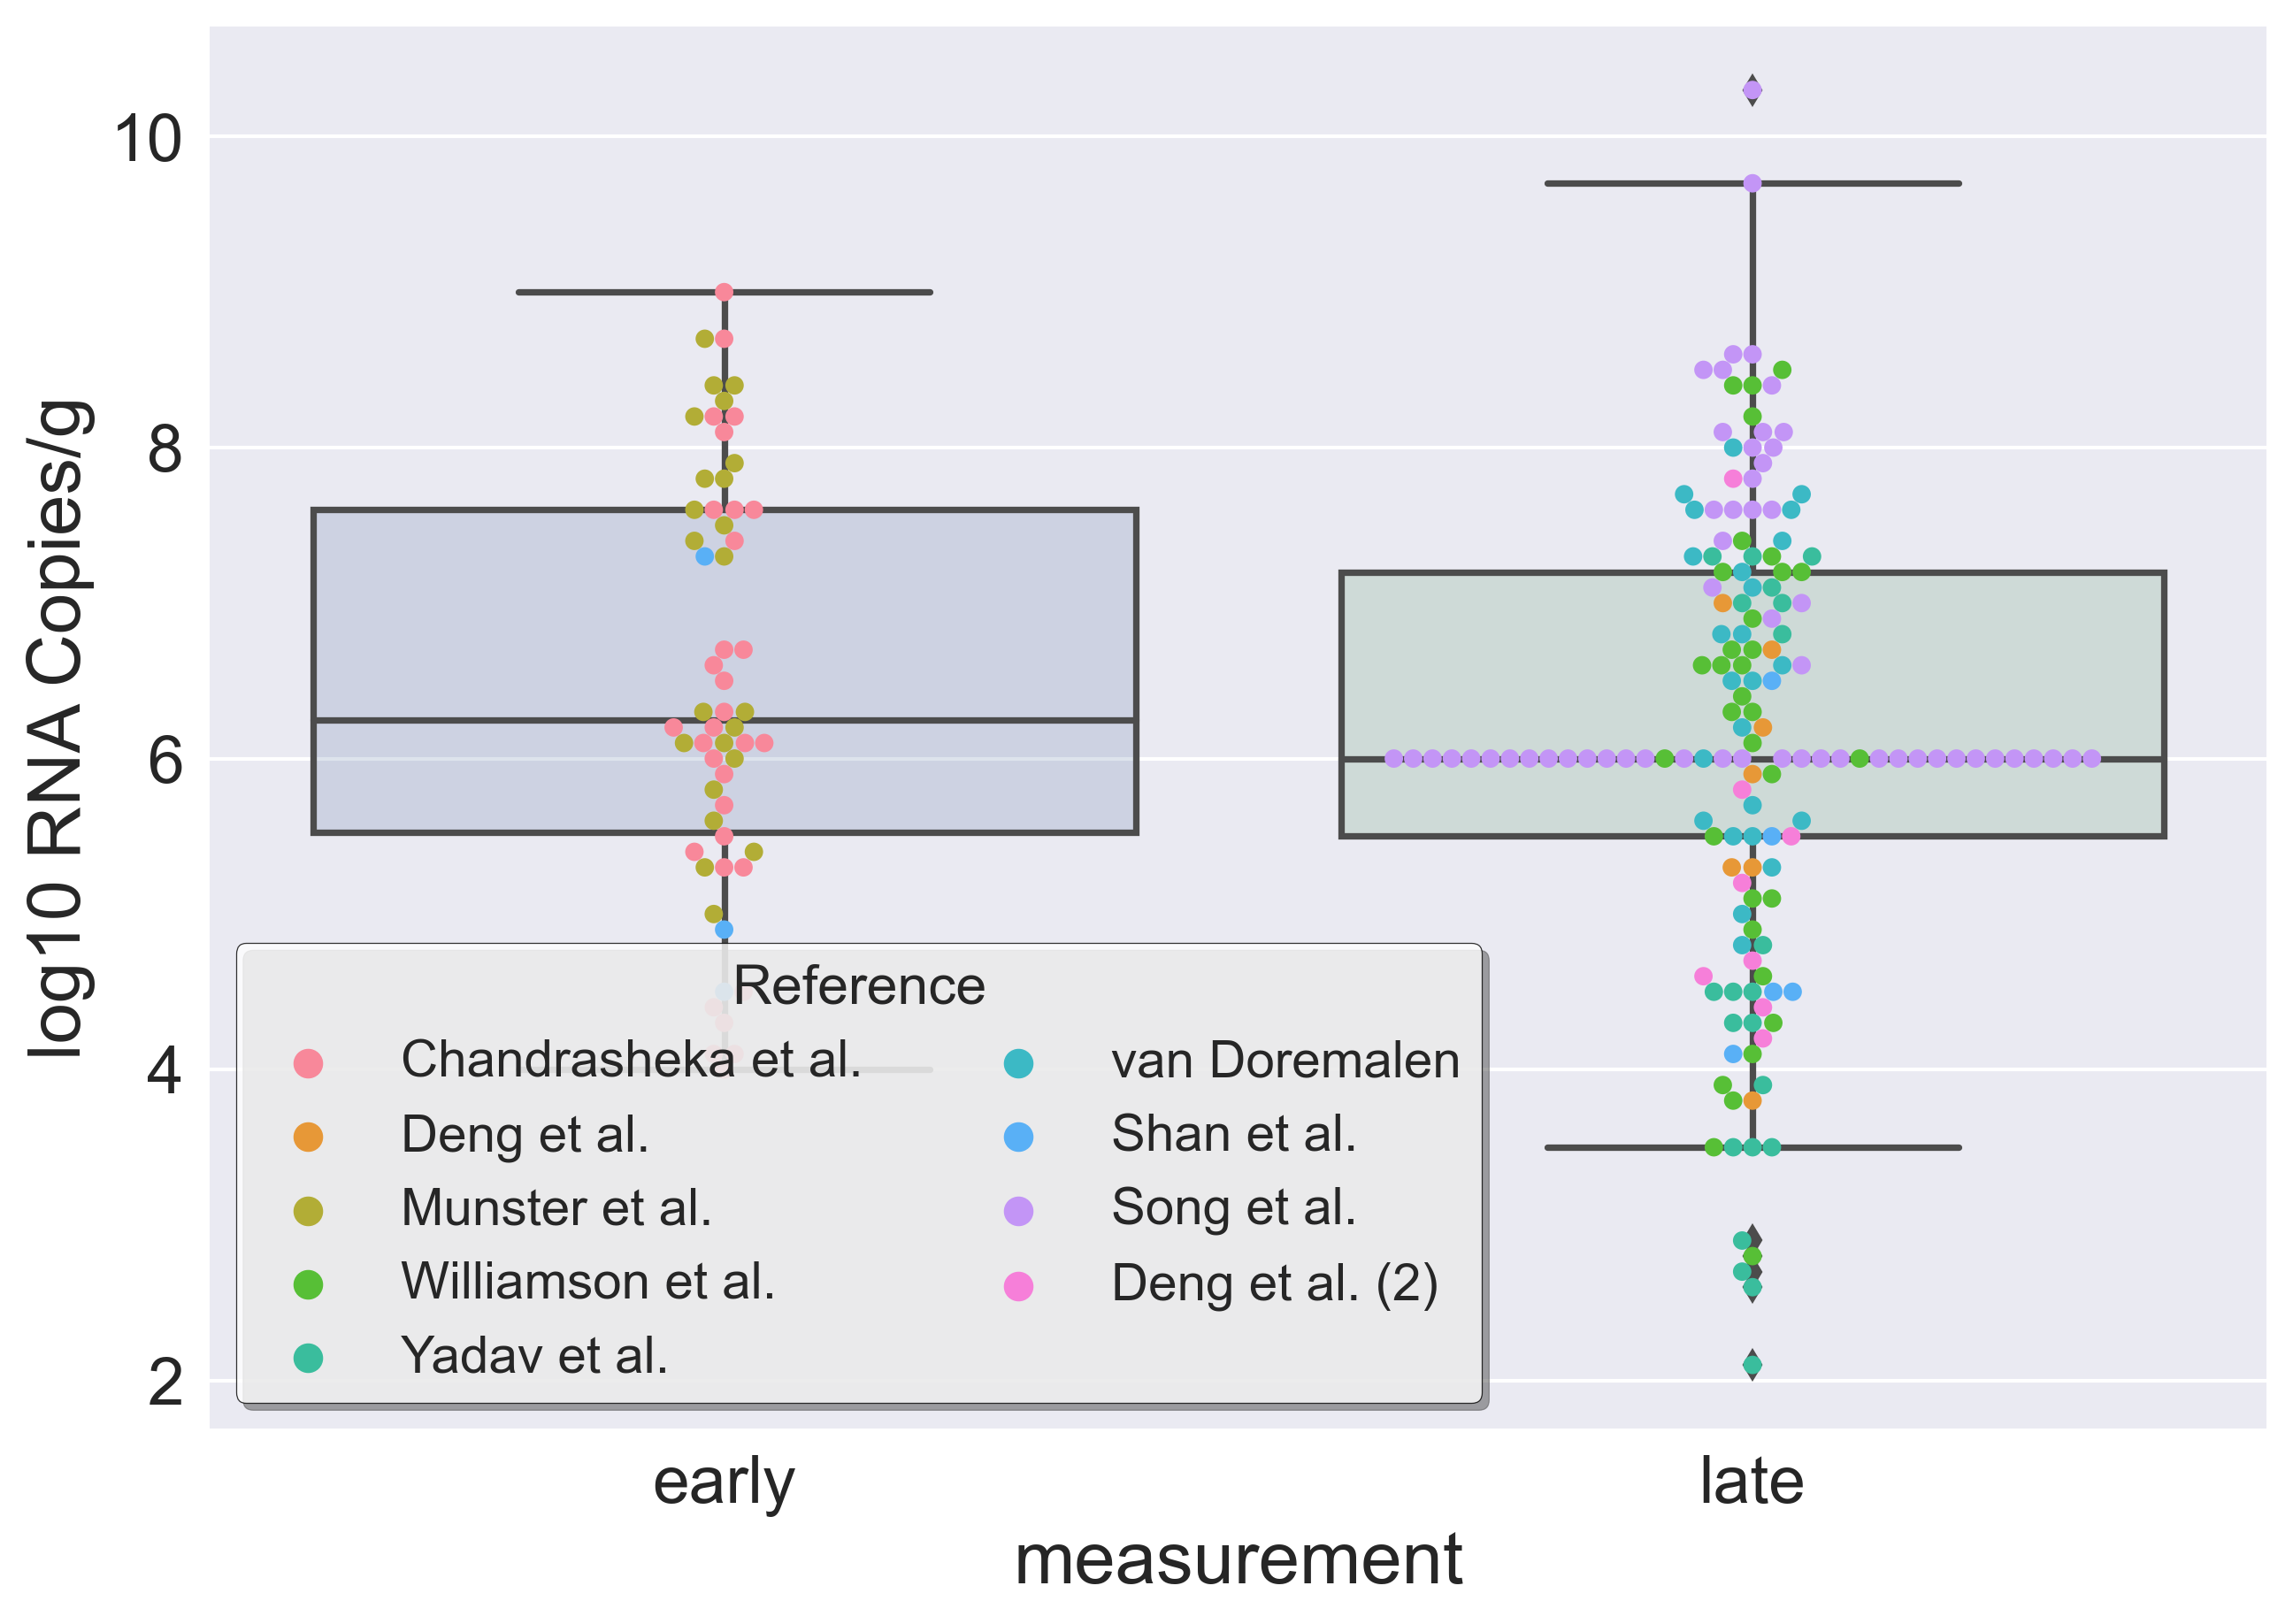

In [27]:

lungs_all_measures = filt_data[filt_data.Location == 'Lungs']
sns.boxplot(data=lungs_all_measures, x='measurement', y='log10 RNA Copies/g')
sns.swarmplot(data=lungs_all_measures, x='measurement', y='log10 RNA Copies/g', hue='Reference')
plt.legend(title='Reference', loc='lower left', fontsize=14, ncol=2)
for patch in plt.gca().artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
plt.savefig('boxplot all measurements in RM.png')

We can also plot the measurement taken from each animal separately

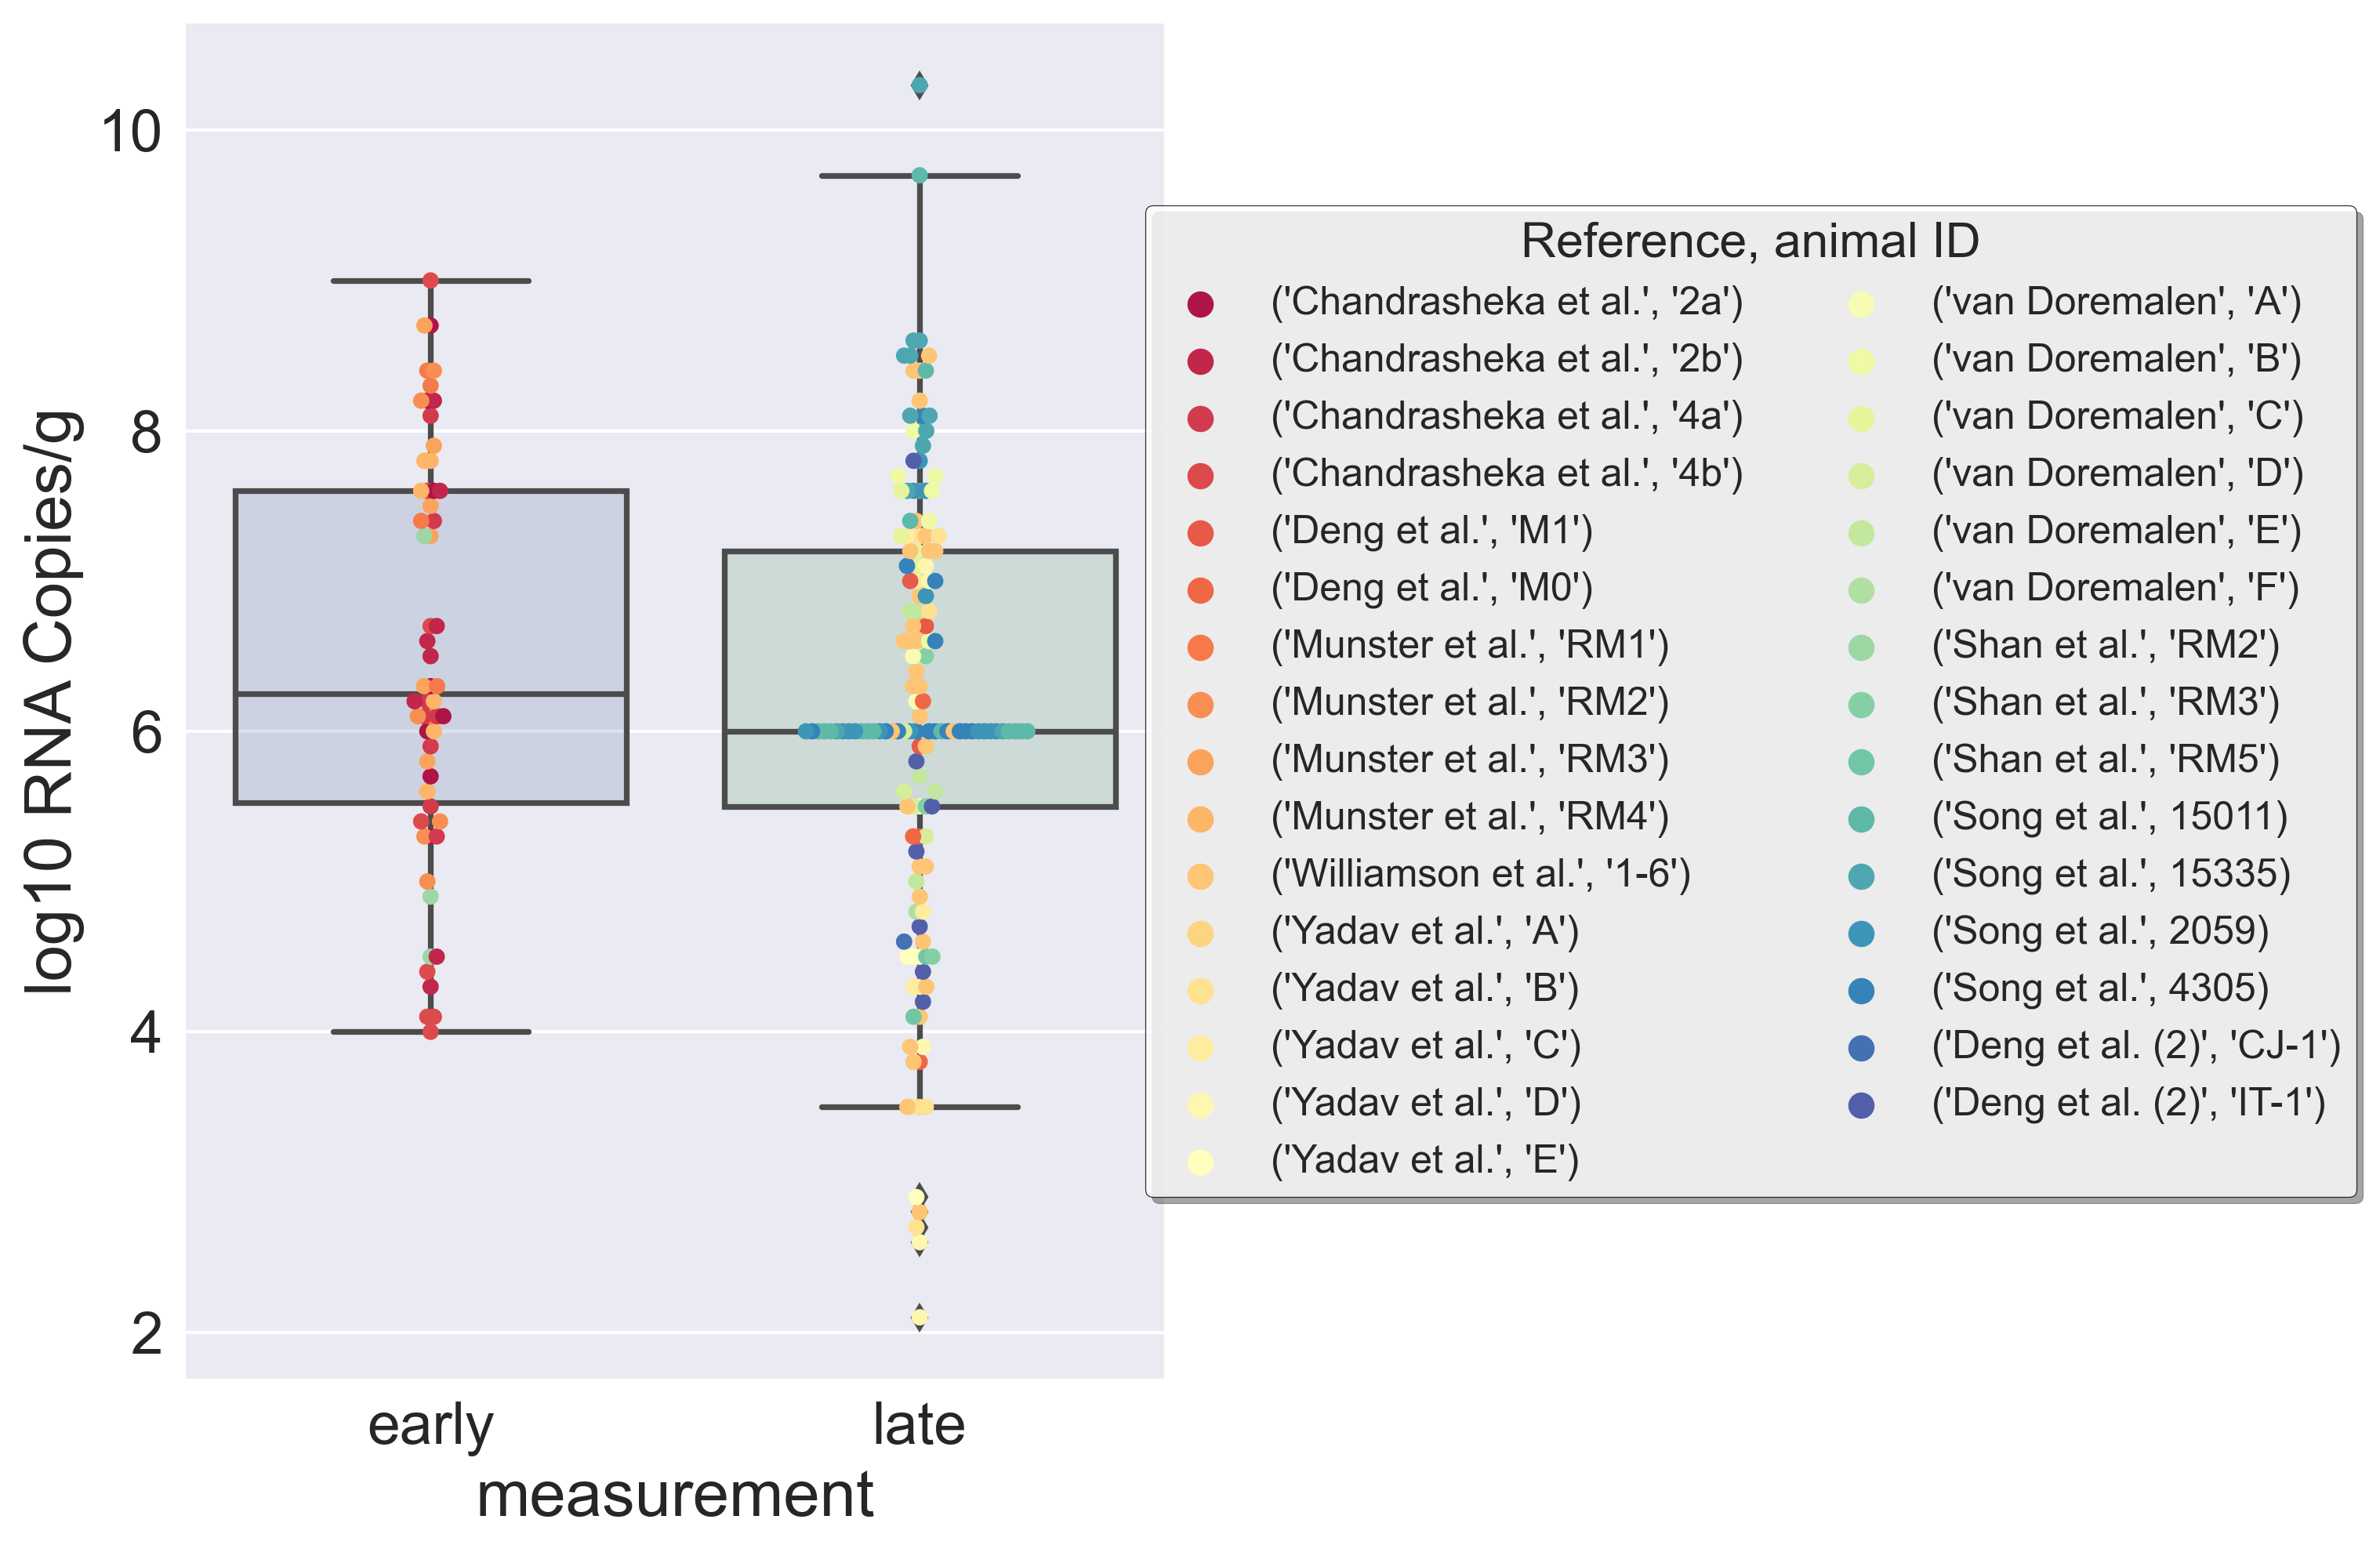

In [28]:
plt.figure().set_size_inches(15,7)
id_2 = list(zip(lungs_all_measures['Reference'].values,lungs_all_measures['animal ID'].values))
sns.boxplot(data=lungs_all_measures, x='measurement', y='log10 RNA Copies/g')
sns.swarmplot(data=lungs_all_measures, x='measurement', y='log10 RNA Copies/g', hue=id_2, palette='Spectral')
plt.legend(title='Reference, animal ID', loc='center', fontsize=12, ncol=2, bbox_to_anchor=(1.6,0.5))
for patch in plt.gca().artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
plt.tight_layout()
plt.savefig('boxplot all measurements in RM.png')

### The distribution of measurements according to tissues
The next figure show how the concentrations vary among the different tissues, when divided according to the threshold of 4-days since inoculation to sample

In [55]:
filt_data.loc[filt_data.Location == 'Trachea and Bronchus' ,'Location'] = 'Trachea and\nBronchus'
filt_data.loc[filt_data.Location == 'Nasal and Oropharynx' ,'Location'] = 'Nasal and\nOropharynx'

sns.boxplot(data=filt_data,x='Location', y='log10 RNA Copies/g', hue='measurement')
sns.swarmplot(data=filt_data,x='Location', y='log10 RNA Copies/g', hue='measurement', dodge=True)
for patch in plt.gca().artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .5))
handles, labels = plt.gca().get_legend_handles_labels() 
plt.legend(handles=handles[:2], labels=labels[:2], loc='best')
plt.xlabel('tissue')
plt.tight_layout()
plt.savefig('boxplot all measurements by tissue.png')



C:\Users\ronse\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 15.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [39]:
#defining univariate function for summary of the measurements by sample
def nan_perc_25(v):
    return np.percentile(v[~np.isnan(v)],q=25)
def nan_perc_75(v):
    return np.percentile(v[~np.isnan(v)],q=75)
def nan_count(v):
    return v[~np.isnan(v)].size

In [40]:
agg_dict = {'log10 RNA Copies/g': ['mean', 'median', nan_perc_25, nan_perc_75, 'std','count'],
            'Reference': pd.Series.nunique}
summ_by_measure = filt_data.groupby(['Location','measurement']).agg(agg_dict)
summ_by_measure.columns = ['mean_measures', 'median_measures', 'perc_25_measures', 'perc_75_measures', 'std_measures', 'measurements_num', 'diff_refs']
summ_by_measure.round(2)


mean_measures  median_measures  \
Location              measurement                                   
GI                    early                 3.84             3.90   
                      late                  2.92             3.00   
Lungs                 early                 6.49             6.25   
                      late                  6.15             6.00   
Nasal and\nOropharynx early                 5.54             5.40   
                      late                  4.70             4.40   
Tonsil and LN         early                 6.35             6.50   
                      late                  4.41             4.30   
Trachea and\nBronchus early                 5.73             5.50   
                      late                  4.76             4.70   

                                   perc_25_measures  perc_75_measures  \
Location              measurement                                       
GI                    early                    3.50              4.20   
                      late                     1.10              4.40   
Lungs                 early                    5.52              7.60   
                      late                     5.50              7.20   
Nasal and\nOropharynx early                    5.10              5.88   
                      late                     3.70              6.10   
Tonsil and LN         early                    5.60              7.17   
                      late                     3.60              5.40   
Trachea and\nBronchus early                    4.62              6.70   
                      late                     4.00              5.38   

                                   std_measures  measurements_num  diff_refs  
Location              measurement                                             
GI                    early                0.65                 9          2  
                      late                 1.62                 9          2  
Lungs                 early                1.35                58          3  
                      late                 1.46               154          7  
Nasal and\nOropharynx early                0.96                14          2  
                      late                 1.69                21          5  
Tonsil and LN         early                1.20                16          2  
                      late                 1.17                13          3  
Trachea and\nBronchus early                1.26                18          3  
                      late                 1.36                12          5

## TCID50 data
Only two studies measured the concentrations using titers. One of those, Rockx et al. didn't differentiate between animals. Hence we aggregate only by measurements

In [47]:
tcid_data = merg_data[~merg_data['log10 TCID/g'].isnull()].copy()
tcid_data.loc[tcid_data['log10 TCID/g'] =='<L.O.D.', 'log10 TCID/g'] = np.nan
tcid_data['log10 TCID/g'] = pd.to_numeric(tcid_data['log10 TCID/g'])
tcid_data.rename(columns={'Day (post incoulation)': 'dpi_'}, inplace=True)
tcid_data.dpi_ = pd.to_numeric(tcid_data.dpi_)
tcid_data['measurement'] = 'late'
tcid_data.loc[tcid_data.dpi_ <= thresh, 'measurement'] = 'early'
tcid_data.loc[tcid_data.Location == 'Trachea and Bronchus' ,'Location'] = 'Trachea and\nBronchus'
tcid_data.loc[tcid_data.Location == 'Nasal and Oropharynx' ,'Location'] = 'Nasal and\nOropharynx'


### The distribution of measurements according to tissues
The next figure show how the concentrations vary among the different tissues, when divided according to the threshold of 4-days since inoculation to sample

In [49]:
tis_order = ['Lungs', 'Nasal and\nOropharynx', 'Trachea and\nBronchus', 'Tonsil and LN', 'GI']
sns.boxplot(data=tcid_data,x='Location', y='log10 TCID/g', hue='measurement', order=tis_order)
sns.swarmplot(data=tcid_data,x='Location', y='log10 TCID/g', hue='measurement', dodge=True, order=tis_order)
for patch in plt.gca().artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .5))
handles, labels = plt.gca().get_legend_handles_labels() 
plt.legend(handles=handles[:2], labels=labels[:2], loc='best')
plt.tight_layout()
plt.savefig('boxplot TCID measurements by tissue.png')



Summarazing using the statistics function defined above:

In [50]:
agg_dict = {'log10 TCID/g': ['mean', 'median', nan_perc_25, nan_perc_75, 'std','count'],
            'Reference': pd.Series.nunique}
summ_tcid_by_measure = tcid_data.groupby(['Location','measurement']).agg(agg_dict)
summ_tcid_by_measure.columns = ['mean_measures', 'median_measures', 'perc_25_measures', 'perc_75_measures', 'std_measures', 'measurements_num', 'diff_refs']
summ_tcid_by_measure.round(2)

mean_measures  median_measures  \
Location              measurement                                   
GI                    early                 1.20              0.5   
Lungs                 early                 2.76              2.7   
                      late                  3.22              3.0   
Nasal and\nOropharynx early                 1.30              0.7   
Tonsil and LN         early                 1.60              1.7   
Trachea and\nBronchus early                 1.32              1.6   

                                   perc_25_measures  perc_75_measures  \
Location              measurement                                       
GI                    early                    0.40              1.65   
Lungs                 early                    2.35              3.55   
                      late                     2.60              3.52   
Nasal and\nOropharynx early                    0.60              1.70   
Tonsil and LN         early                    0.90              2.40   
Trachea and\nBronchus early                    0.68              1.92   

                                   std_measures  measurements_num  diff_refs  
Location              measurement                                             
GI                    early                1.39                 3          1  
Lungs                 early                1.11                 7          1  
                      late                 1.15                 8          1  
Nasal and\nOropharynx early                1.22                 3          1  
Tonsil and LN         early                0.89                 5          1  
Trachea and\nBronchus early                0.87                 8          1

## Saving the results
Saving to an excel file, where each spreadsheet is dedicated to a specific type of results: 


In [51]:
with pd.ExcelWriter('summarized_tissue_conc.xlsx') as writer:  
    summ_by_measure.round(2).to_excel(writer, sheet_name='measurements')
    summ_by_animal.round(2).to_excel(writer, sheet_name='animals')
    summ_tcid_by_measure.round(2).to_excel(writer, sheet_name='TCID_measurements')

## S2 - Combined figure
We combine three of the above figures as panels in a summarized graph

In [58]:
fig, axes = plt.subplots(3,1)
fig.set_size_inches(12,20)

# Panel A - the viral concentrations in the lungs, log10 RNA copies/g - given per animal 
axes[0].errorbar(lungs_by_animals.dpi + jit, lungs_by_animals['nanmean'].values.squeeze(), yerr=lungs_by_animals['nanstd'].values.squeeze(),
 ls='None', c='k', zorder=0.6)
axes[0].errorbar(lungs_by_animals.dpi + jit, lungs_by_animals['nanmean'].values.squeeze(), yerr=lungs_by_animals['nansem'].values.squeeze(),
 ls='None', c='grey', zorder=1)

sns.scatterplot(data=lungs_by_animals, x=lungs_by_animals.dpi + jit, y=('nanmean','log10 RNA Copies/g'), hue=lungs_by_animals.index.get_level_values(0), ax=axes[0])

#adding lines for sem, std to the legend
handles, labels = axes[0].get_legend_handles_labels() 
handles.append(Line2D([0],[0], lw=1.5, color='k',label='standard deviation'))
labels.append('standard deviation')
handles.append(Line2D([0],[0], lw=1.5, color='grey',label='standard error (SEM)'))
labels.append('standard error (SEM)')

width_fact =  0.86
lgnd1 = axes[0].legend(handles=handles, labels=labels, title='Reference', title_fontsize=11, fontsize=10, loc='center', bbox_to_anchor=(0.98/width_fact,0.5), ncol=1)

# Shrink current axis by 20%
box = axes[0].get_position()
axes[0].set_position([box.x0, box.y0, box.width * width_fact, box.height])
axes[0].set_ylabel('Mean log10 RNA copies/g')
axes[0].set_ylim([0,10])
axes[0].set_xlabel('Days post inoculation')
axes[0].text(1.1,10.8,s='A')


# Panel B - the viral concentrations in the different tissues, log10 RNA copies/g - given per tissue, divided by the threshold of 4 dpi
sns.boxplot(data=filt_data,x='Location', y='log10 RNA Copies/g', hue='measurement', ax=axes[1])
sns.swarmplot(data=filt_data,x='Location', y='log10 RNA Copies/g', hue='measurement', dodge=True, ax=axes[1])
for patch in axes[1].artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .5))
handles, labels = axes[1].get_legend_handles_labels() 
axes[1].legend(handles=handles[:2], labels=labels[:2], loc='best')
axes[1].set_xlabel('Tissue')
axes[1].set_ylabel('Log10 RNA copies/g')
axes[1].text(-0.8,11.5,s='B')


# Panel C - the viral concentrations in the different tissues, TCID50/g - given per tissue, divided by the threshold of 4 dpi
sns.boxplot(data=tcid_data,x='Location', y='log10 TCID/g', hue='measurement', ax=axes[2], order=tis_order)
sns.swarmplot(data=tcid_data,x='Location', y='log10 TCID/g', hue='measurement', dodge=True, ax=axes[2], order=tis_order)
for patch in axes[2].artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .5))
handles, labels = axes[2].get_legend_handles_labels() 
axes[2].legend(handles=handles[:2], labels=labels[:2], loc='best')
axes[2].set_xlabel('Tissue')
axes[2].set_ylabel('Log10 TCID50/g')
axes[2].text(-0.8,6.5,s='C')

# plt.tight_layout()
plt.savefig('combined figure.png')
plt.savefig('combined figure.svg')

C:\Users\ronse\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 14.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
